In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
from scipy.optimize import linprog

## 5.2.3 Computing equilibria: the sequence form

A sequence is a set of actions that a player can take in order to get to some node $h$ from the root. In a perfect recall game, there will be one sequence per player per node. A sequence only covers your own actions. A reward function is also added with the amount each player gains if they both play their sequences. Consider this game:

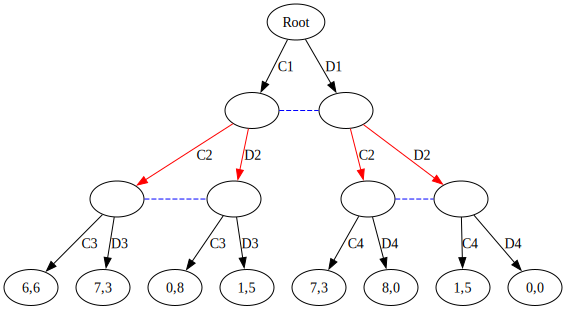

In [2]:
graph = Digraph()
graph.node('Root', 'Root')
graph.node('A', '')
graph.node('B', '')
graph.edge('Root', 'A','C1',color="black")
graph.edge('Root', 'B','D1',color="black")
graph.edge('A', 'B','',color="blue",style="dashed",dir="none")
with graph.subgraph() as same_rank:
    same_rank.attr(rank='same')
    same_rank.node('A')
    same_rank.node('B')
graph.node('C', '')
graph.node('D', '')
graph.edge('A', 'C','C2',color="red")
graph.edge('A', 'D','D2',color="red")
graph.node('E', '')
graph.node('F', '')
graph.edge('B', 'E','C2',color="red")
graph.edge('B', 'F','D2',color="red")
graph.edge('C', 'D','',color="blue",style="dashed",dir="none")
graph.edge('E', 'F','',color="blue",style="dashed",dir="none")
with graph.subgraph() as same_rank:
    same_rank.attr(rank='same')
    same_rank.node('C')
    same_rank.node('D')
    same_rank.node('E')
    same_rank.node('F')
graph.node('G', '6,6')
graph.node('H', '7,3')
graph.edge('C', 'G','C3',color="black")
graph.edge('C', 'H','D3',color="black")
graph.node('I', '0,8')
graph.node('J', '1,5')
graph.edge('D', 'I','C3',color="black")
graph.edge('D', 'J','D3',color="black")
graph.node('K', '7,3')
graph.node('L', '8,0')
graph.edge('E', 'K','C4',color="black")
graph.edge('E', 'L','D4',color="black")
graph.node('M', '1,5')
graph.node('N', '0,0')
graph.edge('F', 'M','C4',color="black")
graph.edge('F', 'N','D4',color="black")
display(graph)

The below table shows the possible sequences and rewards, where $\theta$ is the root. Where the combination of sequences doesn't lead to a leaf the value is 0 and colored in gray.

$
\begin{array}{c|ccc}
\text{} & \emptyset & \text{C2} & \text{D2} \\
\hline
\emptyset & \textcolor{gray}{0,0} & \textcolor{gray}{0,0} & \textcolor{gray}{0,0} \\
\text{C1} & \textcolor{gray}{0,0} & \textcolor{gray}{0,0} & \textcolor{gray}{0,0} \\
\text{D1} & \textcolor{gray}{0,0} & \textcolor{gray}{0,0} & \textcolor{gray}{0,0} \\
\text{C1,C3} & \textcolor{gray}{0,0} & 6,6 & 0,8 \\
\text{C1,D3} & \textcolor{gray}{0,0} & 7,3 & 1,5 \\
\text{D1,C4} & \textcolor{gray}{0,0} & 7,3 & 1,5 \\
\text{D1,D4} & \textcolor{gray}{0,0} & 8,0 & 0,0 \\
\end{array}
$

In practice this means we can use a smaller table and only store values for the leaf nodes. The full mixed strategy space (with a lot of redundancy!) is:

$
\begin{array}{c|cc}
\text{} & \text{C2} & \text{D2} \\
\hline
\text{C1,C3,C4} & 6,6 & 0,8 \\
\text{C1,C3,D4} & 6,6 & 0,8 \\
\text{C1,D3,C4} & 7,3 & 1,5 \\
\text{C1,D3,D4} & 7,3 & 1,5 \\
\text{D1,C3,C4} & 7,3 & 1,5 \\
\text{D1,D3,C4} & 7,3 & 1,5 \\
\text{D1,C3,D4} & 8,0 & 0,0 \\
\text{D1,D3,D4} & 8,0 & 0,0 \\
\end{array}
$

We can now define a **realisation plan**, as a function which assigns each sequence a probability. The only condition is that the sum of the probabilities of all sequences which "extend" (i.e., add a single action) to a given sequence must equal the probability of that sequence. In other words as you go up the tree you need to add the probabilities. 

The following is a possible realisation plan:

$
\begin{array}{c|c}
\text{} & p \\
\hline
\emptyset & 1 \\
\text{C1} & \frac{1}{3} \\
\text{D1} & \frac{2}{3} \\
\text{C1,C3} & \frac{1}{9} \\
\text{C1,D3} & \frac{2}{9} \\
\text{D1,C4} & \frac{1}{3} \\
\text{D1,D4} & \frac{1}{3} \\
\end{array}
$

Because each node corresponds to only one sequence the number of constraints in the realisation plan is only equal to the number of constraints.

#### Computing best responses in two-player games

Computing the best response to the other player's realisation plan is a fairly straightforward linear program, where $\sigma_1$ and $\sigma_2$ refer to the sequences of players, and $r_1(\sigma_1)$ is the probability of choosing the sequence, $g_1(\sigma_1,\sigma_2)$ is player 1's reward for playing their strategy, and $I_1$ is all the information sets for player 1.

$$
\begin{align*}
\text{maximise} \quad & \sum_{\sigma_1} \big( \sum_{\sigma_2} g_1(\sigma_1,\sigma_2)r_2(\sigma_2) \big) r_1(\sigma_1) \\
\text{subject to} \quad & r_1(\emptyset)=1 \\
\text{} \quad & \sum_{\sigma_1^{\prime}\in \text{Extension}(I)} r_1(\sigma_1^{\prime})=r_1(\text{Sequence}_1(I)) \quad \forall I\in I_1 \\
\text{} \quad & r_1(\sigma_1)\geq 0 \\
\end{align*}
$$

Looking at the example above let's say player 2 has a realisation plan which is always $C2$. Then we have this linear program:

In [3]:
c = np.array([0,0,0,3,7,7,8])
A_eq = np.array([
    [1,0,0,0,0,0,0], # root equals 1
    [1,-1,-1,0,0,0,0], # C1 or D1 has to equal Root
    [0,1,0,-1,-1,0,0], # C3 or D3 has to equal C1
    [0,0,1,0,0,-1,-1], # C4 or D4 has to equal D1
])
b_eq = np.array([1,0,0,0])
result = linprog(-c, A_eq=A_eq, b_eq=b_eq)
result["x"]

array([ 1.,  0.,  1.,  0., -0.,  0.,  1.])

Unsuprisingly, the choice is D1,D4.

We can also take the dual of this problem, which gives a slightly different interpretation. In the dual the variables represent the value of each information set, weighed by the probabilities above it. This is a bit hard to explain. The leaf nodes are just the reward function. Every other variable is then at least the sum of the rewards of the nodes below:

$$
\begin{align*}
\text{minimise} \quad v_0 \\
\text{subject to} \quad & V_I(\sigma_1) - \sum_{\text{child}\in \text{extension}(\sigma_1)} V_I(\text{child}) \geq \sum_{\sigma_2} g_1(\sigma_1,\sigma_2)r_2(\sigma_2) \quad \forall \sigma_1 \\
\end{align*}
$$

In [4]:
c = np.array([1,0,0,0,0,0,0])
A_gr = np.array([
    [1,-1,-1,0,0,0,0],
    [0,1,0,-1,-1,0,0],
    [0,0,1,0,0,-1,-1],
    [0,0,0,1,0,0,0],
    [0,0,0,0,1,0,0],
    [0,0,0,0,0,1,0],
    [0,0,0,0,0,0,1],
])
b_gr = np.array([0,0,0,6,7,7,8])
result = linprog(c, -A_gr, -b_gr)
result["x"]

array([28., 13., 15.,  6.,  7.,  7.,  8.])

I think this is right? Note that if we apply the strategy corresponding to the highest score at each node we get the same answer.

Unfortunately, the problem of finding an equilibrium remains difficult to solve even with these changes. There is a more general version of the Lemke-Howson algorithm (called the Lemke algorithm) which solves the problem on a sequence-form game, and is exponentially faster than the usual method for a normal-form game. 

## 5.2.4 Sequential equilibria

From before we had the idea of a subgame equilibria. It turned out that the concept of a Nash equilibria for a sequential game was unsatisfying. A nash equilibria assumes that both players commit to strategies before. But in reality players see the game unfold and may change their strategy. In fact, players can be relied on to change their behaviour. The notion of a subgame-perfect equilibrium was introduced. A strategy profile is a subgame-perfect equilibrium if at every stage the player is doing an optimal action given their current game. Consider this:

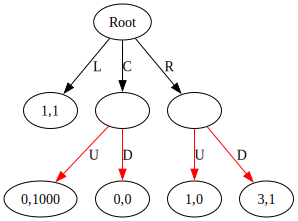

In [5]:
graph = Digraph()
graph.node('Root', 'Root')
graph.node('L', '1,1')
graph.node('C', '')
graph.node('R', '')
graph.edge('Root', 'L','L',color="black")
graph.edge('Root', 'C','C',color="black")
graph.edge('Root', 'R','R',color="black")
graph.node('U1', '0,1000')
graph.node('D1', '0,0')
graph.edge('C', 'U1','U',color="red")
graph.edge('C', 'D1','D',color="red")
graph.node('U2', '1,0')
graph.node('D2', '3,1')
graph.edge('R', 'U2','U',color="red")
graph.edge('R', 'D2','D',color="red")
display(graph)

The payoffs are:

$
\begin{array}{c|cc}
\text{} & U & D \\
\hline
\text{L} & 1,1 & 1,1\\
\text{C} & 0,1000 & 0,0\\
\text{R} & 1,0 & 3,1\\
\end{array}
$

There are two Nash equilibria: LU and RD. You can see this more clearly maybe in the table. But it's a bit odd! In truth player 1 would realise if they do R then player 2 will go D, which is better for player 1 than LU. The only true equilibria is then RD. We can see this if we compute the subgames. In this case the subgames are trivial as each player just makes the best decision they can. We can see that the result is RD:

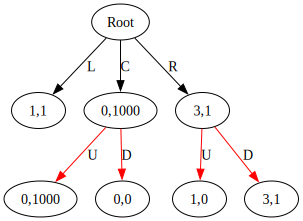

In [6]:
graph = Digraph()
graph.node('Root', 'Root')
graph.node('L', '1,1')
graph.node('C', '0,1000')
graph.node('R', '3,1')
graph.edge('Root', 'L','L',color="black")
graph.edge('Root', 'C','C',color="black")
graph.edge('Root', 'R','R',color="black")
graph.node('U1', '0,1000')
graph.node('D1', '0,0')
graph.edge('C', 'U1','U',color="red")
graph.edge('C', 'D1','D',color="red")
graph.node('U2', '1,0')
graph.node('D2', '3,1')
graph.edge('R', 'U2','U',color="red")
graph.edge('R', 'D2','D',color="red")
display(graph)

When it comes to imperfect-information games this concept is extended into "sequential equilibria" and gets a bit more complicated. Let's assume that the second player doesn't know what the first did. Then we get something more like this:

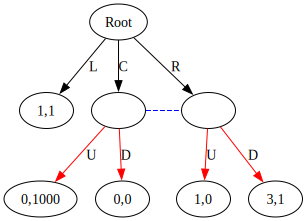

In [7]:
graph = Digraph()
graph.node('Root', 'Root')
graph.node('L', '1,1')
graph.node('C', '')
graph.node('R', '')
with graph.subgraph() as same_rank:
    same_rank.attr(rank='same')
    same_rank.node('L')
    same_rank.node('C')
    same_rank.node('R')
graph.edge('Root', 'L','L',color="black")
graph.edge('Root', 'C','C',color="black")
graph.edge('Root', 'R','R',color="black")
graph.edge('C', 'R','',color="blue",style="dashed",dir="none")
graph.node('U1', '0,1000')
graph.node('D1', '0,0')
graph.edge('C', 'U1','U',color="red")
graph.edge('C', 'D1','D',color="red")
graph.node('U2', '1,0')
graph.node('D2', '3,1')
graph.edge('R', 'U2','U',color="red")
graph.edge('R', 'D2','D',color="red")
display(graph)

We can no longer just push back the values, because what player 2 will do is dependent on what player 1 does. We have to deal with a forest of subgames. Notice that the subgame from C and from R have different optimal solutions! So we can't use the subgame-perfect equilibrium logic. 

With a sequential equilibrium we check at any single decision point (information set) the probability of what state we are in and what states we will go to, given both strategies. Then we check that the agent making the decision is unwilling to change their plan. Essentially this means we are computing the whole tree given the strategies, and then choosing the optimal results.

Because there is one additional point of complexity to see a brief example just consider the matching penies game:

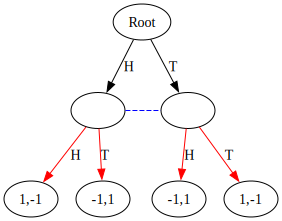

In [8]:
graph = Digraph()
graph.node('Root', 'Root')
graph.node('H1', '')
graph.node('T1', '')
graph.edge('Root', 'H1','H',color="black")
graph.edge('Root', 'T1','T',color="black")
graph.edge('H1', 'T1','',color="blue",style="dashed",dir="none")
with graph.subgraph() as same_rank:
    same_rank.attr(rank='same')
    same_rank.node('H1')
    same_rank.node('T1')
graph.node('H2', '1,-1')
graph.node('T2', '-1,1')
graph.node('H3', '-1,1')
graph.node('T3', '1,-1')
graph.edge('H1', 'H2','H',color="red")
graph.edge('H1', 'T2','T',color="red")
graph.edge('T1', 'H3','H',color="red")
graph.edge('T1', 'T3','T',color="red")
display(graph)

And let's check the strategy where both players go 50:50. It is pretty easy to compute the belief function for both information sets. For the first player they are 100% in the Root node. For the second player they are 50:50 in H or T. We can then calculate the probability of the outcomes:

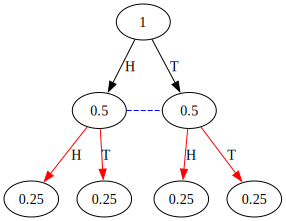

In [9]:
graph = Digraph()
graph.node('Root', '1')
graph.node('H1', '0.5')
graph.node('T1', '0.5')
graph.edge('Root', 'H1','H',color="black")
graph.edge('Root', 'T1','T',color="black")
graph.edge('H1', 'T1','',color="blue",style="dashed",dir="none")
with graph.subgraph() as same_rank:
    same_rank.attr(rank='same')
    same_rank.node('H1')
    same_rank.node('T1')
graph.node('H2', '0.25')
graph.node('T2', '0.25')
graph.node('H3', '0.25')
graph.node('T3', '0.25')
graph.edge('H1', 'H2','H',color="red")
graph.edge('H1', 'T2','T',color="red")
graph.edge('T1', 'H3','H',color="red")
graph.edge('T1', 'T3','T',color="red")
display(graph)

And push back the utilities to previous nodes:

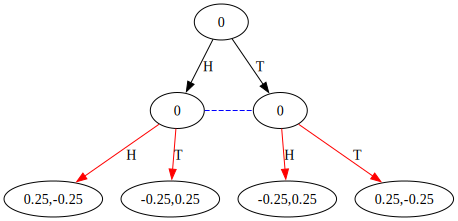

In [10]:
graph = Digraph()
graph.node('Root', '0')
graph.node('H1', '0')
graph.node('T1', '0')
graph.edge('Root', 'H1','H',color="black")
graph.edge('Root', 'T1','T',color="black")
graph.edge('H1', 'T1','',color="blue",style="dashed",dir="none")
with graph.subgraph() as same_rank:
    same_rank.attr(rank='same')
    same_rank.node('H1')
    same_rank.node('T1')
graph.node('H2', '0.25,-0.25')
graph.node('T2', '-0.25,0.25')
graph.node('H3', '-0.25,0.25')
graph.node('T3', '0.25,-0.25')
graph.edge('H1', 'H2','H',color="red")
graph.edge('H1', 'T2','T',color="red")
graph.edge('T1', 'H3','H',color="red")
graph.edge('T1', 'T3','T',color="red")
display(graph)

We can see that player 1 is given the choice between 0 and 0, so has no incentive to change. We can then check player 2's decision in the same way. Player 2 doesn't see player 1's decision, so the probability of the subsequent states remain the same and it's obvious there is no incentive to change here either.

Now back to the problem from before, which exposes a problem:

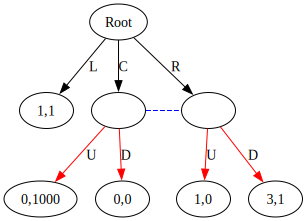

In [11]:
graph = Digraph()
graph.node('Root', 'Root')
graph.node('L', '1,1')
graph.node('C', '')
graph.node('R', '')
with graph.subgraph() as same_rank:
    same_rank.attr(rank='same')
    same_rank.node('L')
    same_rank.node('C')
    same_rank.node('R')
graph.edge('Root', 'L','L',color="black")
graph.edge('Root', 'C','C',color="black")
graph.edge('Root', 'R','R',color="black")
graph.edge('C', 'R','',color="blue",style="dashed",dir="none")
graph.node('U1', '0,1000')
graph.node('D1', '0,0')
graph.edge('C', 'U1','U',color="red")
graph.edge('C', 'D1','D',color="red")
graph.node('U2', '1,0')
graph.node('D2', '3,1')
graph.edge('R', 'U2','U',color="red")
graph.edge('R', 'D2','D',color="red")
display(graph)

Imagine that player 1 has a strategy of L with 100% and player 2 has a strategy of U with 100%. How do we check that this is an equilibrium? The issue is the strategy of player 2 depends on the probability of C and R, which are both 0! In order to get around this we need to make the strategies all have non-zero probabilities. Say we define an infinitely small number $e$ for player 1 going $R$ and we then have the even smaller $e^2$ for player 1 going C. Then we have a fully mixed strategy and can calculate all the probabilities. We then know that player 2 would infer that given it is in C or R it is almost certainly in $R$, and hence the best strategy is D, not U. From there we know player 1 would go R instead. And then checking the results we find neither player would change anymore.

So we needed to make the players choose fully mixed strategies and then this works. The book made this seem more complicated!

As a final note sequential equilibrium doesn't apply to games which are not perfect-recall. Sequential equilibrium is a stronger condition than Nash equilibrium. It more accurately describes players' behaviour and removes irrational steps that a Nash equilibrium might give. But without perfect-recall we are in a totally different world.

Nevertheless, we can still apply the same concept. But it doesn't mean the same thing anymore. 

#### Fun final thought.

Recall the driver with alzheimer's problem. But let's imagine there are two people in the car and if either one wants to exit they exit. Player 1 wants to get off at stop 2, player 2 wants to get off at 3. They both lose if they exit early or go too far. This is the tree. The actions are Continue (C) or Exit (E). This is not perfect-recall!

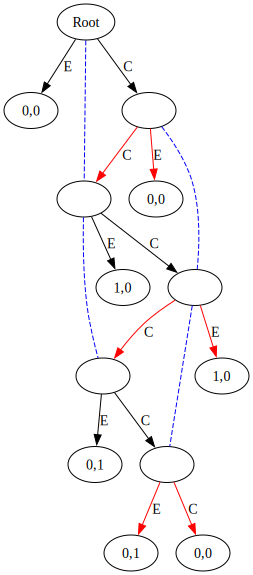

In [14]:
graph = Digraph()
graph.node('Root', 'Root')
graph.node('E1', '0,0')
graph.node('C1', '')
graph.edge('Root', 'E1','E',color="black")
graph.edge('Root', 'C1','C',color="black")
graph.node('E2', '0,0')
graph.node('C2', '')
graph.edge('C1', 'E2','E',color="red")
graph.edge('C1', 'C2','C',color="red")
graph.node('E3', '1,0')
graph.node('C3', '')
graph.edge('C2', 'E3','E',color="black")
graph.edge('C2', 'C3','C',color="black")
graph.node('E4', '1,0')
graph.node('C4', '')
graph.edge('C3', 'E4','E',color="red")
graph.edge('C3', 'C4','C',color="red")
graph.node('E5', '0,1')
graph.node('C5', '')
graph.edge('C4', 'E5','E',color="black")
graph.edge('C4', 'C5','C',color="black")
graph.node('E6', '0,1')
graph.node('C6', '0,0')
graph.edge('C5', 'E6','E',color="red")
graph.edge('C5', 'C6','C',color="red")
graph.edge('Root', 'C2','',color="blue",style="dashed",dir="none")
graph.edge('C2', 'C4','',color="blue",style="dashed",dir="none")
graph.edge('C1', 'C3','',color="blue",style="dashed",dir="none")
graph.edge('C3', 'C5','',color="blue",style="dashed",dir="none")
display(graph)

If we look for a Nash equilibrium we can find one. Essentially both players commit to a strategy at the start. Say that the probability of player 1 exiting is $p$ and the probability of player 2 exiting is $q$. The probabilities of each exit are then:

$$
\begin{aligned}
\text{Exit 1:} \;& p + (1-p)q \\
\text{Exit 2:} \;& (1-p)(1-q)p + (1-p)^2(1-q)q \\
\text{Exit 3:} \;& (1-p)^2(1-q)^2p + (1-p)^3(1-q)^2q \\
\text{Exit 4:} \;& (1-p)^3(1-q)^3 \\
\end{aligned}
$$

We want to know the best strategy of player 1 and player 2. For player 1 because the reward is 0 everywhere and 1 only at exit 2 we just need to maximise the probability of exit 2. Expanding exit 2 probability we get:

$$
\begin{aligned}
\;& (1-p)(1-q)p + (1-p)^2(1-q)q \\
= \;& p-3pq-p^2+2p^2q + q-q^2+2pq^2-p^2q^2 \\
\end{aligned}
$$

And taking the gradient wrt p gives:

$$1-3q-2p+4pq + 2q^2-2pq^2$$

If we take the second derivative we get $-2+4q-2q^2$, which has the factorization $-2(q-1)^2$. This is guaranteed to always be negative, so our parabola is concave. Therefore to maximize we can just set the gradient to 0:

$$
\begin{aligned}
1-3q-2p+4pq + 2q^2-2pq^2 & =0\\
p(-2+4q-2q^2) & = -2q^2 + 3q - 1\\
p & = \frac{-2q^2 + 3q - 1}{-2+4q-2q^2}\\
\end{aligned}
$$

This can then be simplified:

$$
\begin{aligned}
p & = \frac{-2q^2 + 3q - 1}{-2+4q-2q^2}\\
p & = \frac{-2(q-1)^2-(q-1)}{-2(q-1)^2}\\
p & = \frac{-2(q-1)-1}{-2(q-1)}\\
p & = \frac{1-2q}{-2(q-1)}\\
\end{aligned}
$$

For player 2 we care about the probability of Exit 3, wrt $q$. This ends up being:

$$ q = \frac{1-3p}{-3(p-1)} $$

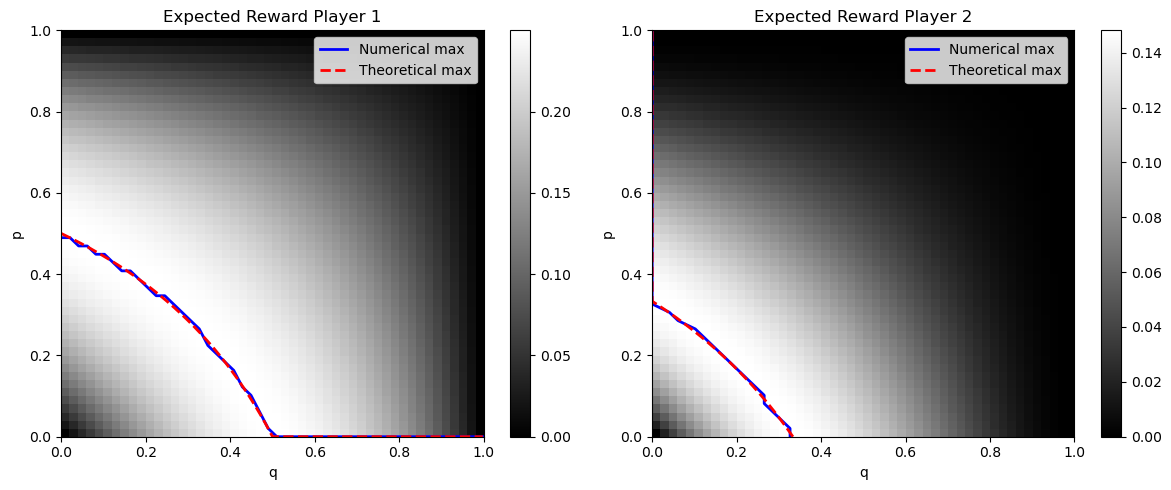

In [28]:
def simulate_both_with_alzheimers(p,q):
    exit_probabilities = [
        p,
        (1-p)*q,
        (1-p)*(1-q)*p,
        (1-p)**2*(1-q)*q,
        (1-p)**2*(1-q)**2*p,
        (1-p)**3*(1-q)**2*q,
        (1-p)**3*(1-q)**3
    ]
    rewards_l = [0,0,1,1,0,0,0]
    rewards_r = [0,0,0,0,1,1,0]
    return np.dot(exit_probabilities,rewards_l), np.dot(exit_probabilities,rewards_r)

# Grid of probabilities
p_vals = np.linspace(0,1,50)
q_vals = np.linspace(0,1,50)

# Initialize matrices
R1 = np.zeros((len(p_vals), len(q_vals)))
R2 = np.zeros((len(p_vals), len(q_vals)))

# Compute expected rewards over the grid
for i, p in enumerate(p_vals):
    for j, q in enumerate(q_vals):
        r1, r2 = simulate_both_with_alzheimers(p,q)
        R1[i,j] = r1
        R2[i,j] = r2

# Compute best-response curves
best_response_p = []  # max R1 w.r.t p for each q
best_response_q = []  # max R2 w.r.t q for each p

for j, q in enumerate(q_vals):
    idx = np.argmax(R1[:, j])
    best_response_p.append(p_vals[idx])

for i, p in enumerate(p_vals):
    idx = np.argmax(R2[i, :])
    best_response_q.append(q_vals[idx])

# Theoretical max curve for Player 1
q_sample = np.linspace(0,1,500)
with np.errstate(divide='ignore', invalid='ignore'):
    p_theory = (1-2*q_sample)/(-2*(q_sample-1))
p_theory = np.maximum(p_theory,0)

# Theoretical max curve for Player 2
p_sample = np.linspace(0,1,500)
with np.errstate(divide='ignore', invalid='ignore'):
    q_theory = (1-3*p_sample)/(-3*(p_sample-1))
q_theory = np.maximum(q_theory,0)

fig, axes = plt.subplots(1,2, figsize=(12,5))

im1 = axes[0].imshow(R1, origin='lower', extent=[0,1,0,1], aspect='auto', cmap='gray')
axes[0].plot(q_vals, best_response_p, color='blue', lw=2, label='Numerical max')
axes[0].plot(q_sample, p_theory, color='red', lw=2, ls='--', label='Theoretical max')
axes[0].set_xlabel('q')
axes[0].set_ylabel('p')
axes[0].set_title('Expected Reward Player 1')
axes[0].legend()
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(R2, origin='lower', extent=[0,1,0,1], aspect='auto', cmap='gray')
axes[1].plot(best_response_q, p_vals, color='blue', lw=2, label='Numerical max')
axes[1].plot(q_theory, p_sample, color='red', lw=2, ls='--', label='Theoretical max')
axes[1].set_xlabel('q')
axes[1].set_ylabel('p')
axes[1].set_title('Expected Reward Player 2')
axes[1].legend()
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

Now a Nash equilibrium requries that both players don't change their behaviour. We need to look for points where the two curves intersect for that. We can see the theoretical plots:

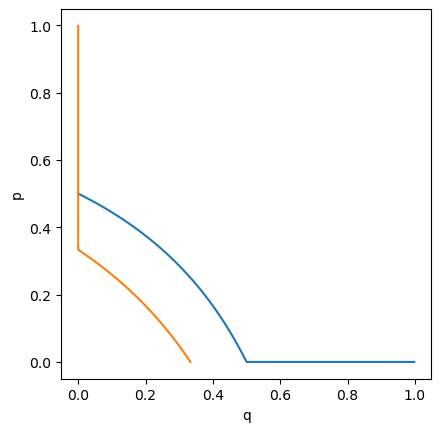

In [35]:
plt.plot(q_sample, p_theory)
plt.plot(q_theory, p_sample)
plt.xlim(-0.01, 1)
plt.ylim(-0.01, 1)
plt.xlabel('q')
plt.ylabel('p')
plt.axis('square')
plt.show()

We can see the two curves intersect at $p=0.5$, $q=0.0$. But this is just the Nash equilibrium. When we talked before about sequential equilibrium it was all about what the players do in their *information set*. You can see this gets quite complicated! I was going to try calculate the optimal behaviour given the information set, but now I'm too exhausted by this!